# Bitcoin-Heist Ransomware

**Goal**
- Given a bitcoin address along with some meta-data pertaining to that address, we want build a model to predict if that address has been used to receive ransoms in the past.




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import os
import pickle
from sklearn.model_selection import train_test_split

import datetime
from scipy.stats import pearsonr
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from prettytable import PrettyTable

warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)
_ = np.seterr(over='ignore')

from pretty_confusion_matrix import  pp_matrix_from_data

warnings.simplefilter(action='ignore', category=FutureWarning)

### Import data

In [3]:
df = pd.read_csv('BitcoinHeistSmall.csv')
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   address    100000 non-null  object 
 1   year       100000 non-null  int64  
 2   day        100000 non-null  int64  
 3   length     100000 non-null  int64  
 4   weight     100000 non-null  float64
 5   count      100000 non-null  int64  
 6   looped     100000 non-null  int64  
 7   neighbors  100000 non-null  int64  
 8   income     100000 non-null  float64
 9   label      100000 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 7.6+ MB


In [5]:
# check unique labels
df['label'].unique()

array(['princetonCerber', 'princetonLocky', 'montrealCryptoLocker',
       'montrealCryptXXX', 'paduaCryptoWall', 'montrealWannaCry',
       'montrealDMALockerv3', 'montrealCryptoTorLocker2015',
       'montrealSamSam', 'montrealFlyper', 'montrealNoobCrypt',
       'montrealDMALocker', 'montrealGlobe', 'montrealEDA2',
       'paduaKeRanger', 'montrealVenusLocker', 'montrealXTPLocker',
       'paduaJigsaw', 'montrealGlobev3', 'montrealJigSaw',
       'montrealXLockerv5.0', 'montrealXLocker', 'montrealRazy',
       'montrealCryptConsole', 'montrealGlobeImposter', 'montrealSam',
       'montrealComradeCircle', 'montrealAPT', 'white'], dtype=object)

### **The target Variable**

The target, or the entity we want to predict for a given transaction, is a set of labels. A label can either be white, indicating that the address corresponding to a particular transaction was NOT used for malicious intent or, it can belong to a set of labels such as paduaCryptoWall, montrealSam, princetonLocky, etc, each of which is the name of a particular family of ransomware.
For the task at hand, we do not need to worry about what family particular ransomware belongs to, but only if whether an address corresponding to a transaction has been used for malicious intent or not. Thus, we convert this multi-class classification task into a binary-class classification. Another reason this is beneficial is in the distribution of our target feature. It is extremely skewed i.e., we have an extremely imbalanced dataset.

In [6]:
df['label'] = df['label'].map({'white':0, 'princetonCerber':1, 'montrealCryptoLocker':1,
       'montrealCryptXXX':1, 'paduaCryptoWall':1, 'montrealWannaCry':1,
       'montrealDMALockerv3':1, 'montrealCryptoTorLocker2015':1,
       'montrealSamSam':1, 'montrealFlyper':1, 'montrealNoobCrypt':1,
       'montrealDMALocker':1, 'montrealGlobe':1, 'montrealEDA2':1,
       'paduaKeRanger':1, 'montrealVenusLocker':1, 'montrealXTPLocker':1,
       'paduaJigsaw':1, 'montrealGlobev3':1, 'montrealJigSaw':1,
       'montrealXLockerv5.0':1, 'montrealXLocker':1, 'montrealRazy':1,
       'montrealCryptConsole':1, 'montrealGlobeImposter':1, 'montrealSam':1,
       'montrealComradeCircle':1, 'montrealAPT':1})

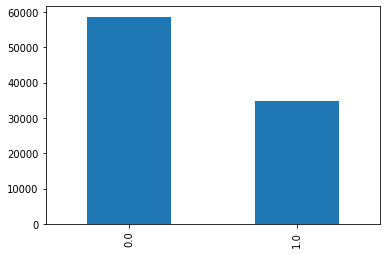

In [7]:
# checking for class imbalance
df['label'].value_counts().plot(kind='bar');

In [8]:
print(f"Number of white (non-ransomware) datapoints:\
{df['label'].value_counts()[0]}\nNumber of ransomware datapoints: {df['label'].value_counts()[1]}")


Number of white (non-ransomware) datapoints:58587
Number of ransomware datapoints: 34788


### Checking for missing values

In [9]:
df.isnull().sum()

address         0
year            0
day             0
length          0
weight          0
count           0
looped          0
neighbors       0
income          0
label        6625
dtype: int64

# Data Cleaning and Feature Engineering


In [10]:
# Drop duplicate rows
df = df.drop_duplicates()

Drop missing values for now

In [11]:
df = df.dropna()
df['label'].isnull().sum()

0

### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['label'], axis=1), 
    df['label'],
    stratify = df['label'], #Having equal number of positive class in both training and testing
    random_state = 42,
    test_size = 0.2
)

In [13]:
y_train.value_counts()/len(y_train)

0.0    0.627443
1.0    0.372557
Name: label, dtype: float64

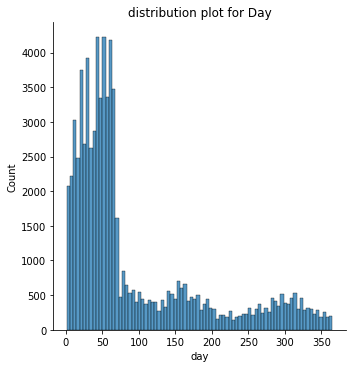

In [14]:
sns.displot(X_train['day'])
plt.title("distribution plot for Day")
plt.show()

### Constructing new feature: quarter_number
This feature indicates which quarter of the year the day number belongs to

In [15]:
def get_quarter(day):
    if day <= 91:
        #First 3 months, so we return quarter number = 1
        return 1
    elif day <= 91 * 2:
        #Next 3 months, quarter number = 2
        return 2
    elif day <= 91 * 3:
        #Next 3 months, quarter number = 3
        return 3
    else:
        #Last 4 months, quarter nubmer = 4
        return 4

quarter_number_feature_train = np.array([])
day_train = X_train['day']

for day in day_train:
    #For each day, we append its correspoding quarter number
    quarter_number_feature_train = np.append(quarter_number_feature_train, get_quarter(day))

In [16]:
quarter_number_feature_test = np.array([])
day_test = X_test['day']

for day in day_test:
    #Doing the same for test set
    quarter_number_feature_test = np.append(quarter_number_feature_test, get_quarter(day))

### Length

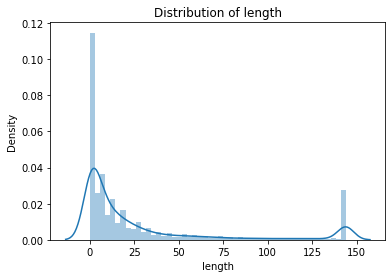

In [17]:
# Looking at the distribution
sns.distplot(X_train['length'])
plt.title('Distribution of length')
plt.plot();

### Constructing new feature: gaussian_length
This feature tries to fix the skewness of the length variable. This is done by applying complex functions over the length feature and then performing a boxcox operation on it

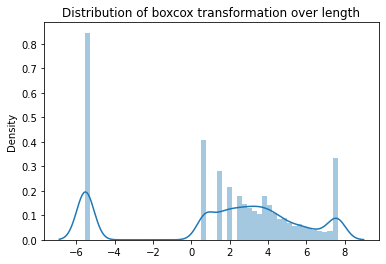

In [18]:
sns.distplot(boxcox(np.array(X_train['length']) + 1e-6)[0])
plt.title('Distribution of boxcox transformation over length')
plt.show();

In [19]:
#constructing the feature
gaussian_length_train = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6)))) ** 2)[0]
gaussian_length_test = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-6)))) ** 2)[0]

### Weight

Weight is also an extremely skewed-feature, thus we will try to fix the skewness

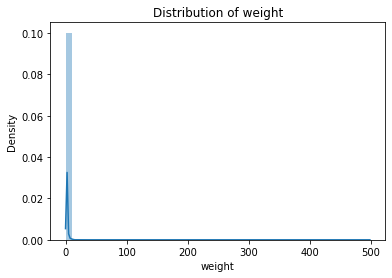

In [20]:
sns.distplot(X_train['weight'])
plt.title('Distribution of weight')
plt.show();

Weight is also an extremely skewed-feature, thus we will try to fix the skewness

- Constructing new feature: gaussian_weight
This feature corrects for the skewedness in weight

In [21]:
#Apply boxcox transform on weight
gaussian_weight_train = np.array(boxcox(np.array(X_train['weight'],  dtype=np.longdouble))[0])
#for test set as well
gaussian_weight_test = np.array(boxcox(np.array(X_test['weight'],  dtype=np.longdouble))[0])

### Income
Looking at the distribution plot

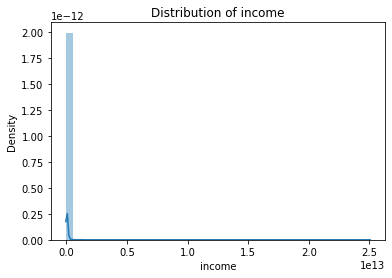

In [22]:
sns.distplot(X_train['income'])
plt.title('Distribution of income')
plt.show()

Again, we see a very skewed distribution for the Income feature

Constructing new feature: gaussian_income
Feature tries to account for the extreme skewedness of income by applying boxcox transformation

In [23]:
#Applying boxcox on income

gaussian_income_train = boxcox(np.array(X_train['income']) + 1e-6)[0]
gaussian_income_test = boxcox(np.array(X_test['income']) + 1e-6)[0]

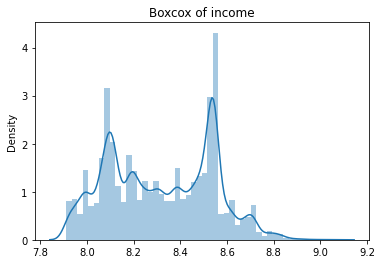

In [24]:
sns.distplot(boxcox(np.array(X_train['income']) + 1e-6)[0])
plt.title('Boxcox of income')
plt.show()

### Adding new features to train and test dataframes

In [25]:
X_train['quarter_number']  = quarter_number_feature_train 
X_train['gaussian_income'] = gaussian_income_train 
X_train['gaussian_weight'] = gaussian_weight_train 
X_train['gaussian_length'] = gaussian_length_train 

In [126]:
X_train.head()

,address,year,day,length,weight,count,looped,neighbors,income,quarter_number,gaussian_income,gaussian_weight,gaussian_length
81822,1gbNLaKt21VMgSE2TQjJpdSo8gD2A2X3m,2011,51,14,5.000000e-01,1,0,2,2.415300e+10,1.0,8.684239,-0.640799,-0.062515
14825,1adoJYratfkmxh2GLV1N1hUjQzmRfy95W,2016,264,2,2.500000e-01,1,0,2,1.250000e+08,3.0,8.125393,-1.187307,-1.164809
94320,1L2uR9kqJbTLD3vp9SnMW1QYcwSGskKPfJ,2011,63,38,1.000000e+00,1,0,2,9.750000e+09,1.0,8.608746,0.000000,-0.060913
37234,1NJBhokXmU6eUw9FdyBfef6h27pnec5nha,2013,296,6,1.083333e+00,2,0,4,2.929000e+08,4.0,8.238188,0.080783,-0.423688
97273,19mHM3yMSM1A7DcndaTKFXBznDvHfeWWx2,2011,66,86,1.818989e-12,2,0,2,1.856000e+10,1.0,8.663061,-4.346122,-0.402336


In [26]:
X_test['quarter_number'] = quarter_number_feature_test 
X_test['gaussian_income'] = gaussian_income_test 
X_test['gaussian_weight'] = gaussian_weight_test 
X_test['gaussian_length'] = gaussian_length_test 

In [27]:
X_test.head()

,address,year,day,length,weight,count,looped,neighbors,income,quarter_number,gaussian_income,gaussian_weight,gaussian_length
44803,1DXsKabUusmayN4e8PjdMx2JQgrk9mdRer,2011,8,8,2.656250,9,0,9,1.848000e+09,1.0,8.298410,1.097871,-0.269758
95057,17Ag7gjE82s24hP3tfL5g7pLA2Mgou4hW3,2011,64,14,0.007812,1,0,2,2.643000e+09,1.0,8.332964,-2.897569,-0.062515
25538,1G9s21qsoiMMp8xYXBRiDdiXH654pSgzsP,2013,281,12,0.173828,3,0,1,2.000000e+08,4.0,8.050769,-1.435184,-0.106002
63385,1BzkMihEoGKJghEjytaKinCtjnUhGyMjZc,2011,31,18,1.750000,4,0,4,4.820000e+08,1.0,8.155938,0.597995,-0.015739
47369,1NH2TFPpbYcjnmXwXavhKq2pPDvQRHuQeL,2011,11,30,0.001953,1,0,2,3.720000e+08,1.0,8.126003,-3.276918,-0.016804


## Preprocessing Data for Modelling
### Standardize the dataset using StandardScaler

In [28]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
X_train = Scaler_X.fit_transform(X_train.drop('address', axis=1))
X_test = Scaler_X.transform(X_test.drop('address', axis=1))

### Fix class imbalance by undersampling the negative class (not ransomware)

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
under_sample = RandomUnderSampler()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_ru, y_train_ru = under_sample.fit_resample(X_train, y_train)

counter = Counter(y_train_ru)
print('After',counter)

Before Counter({0.0: 46870, 1.0: 27830})
After Counter({0.0: 27830, 1.0: 27830})


# Modelling

**Metrics**
Key Performance Indicator : Recall

Recall tells us of all the data-points in the data-set that are actually positive, what percentage of them have we predicted to be positive.
Why?
We want to correctly classify as many positive data-points (ransomware transactions) as possible even if it means we incorreclty classify a few white transactions to be of type ransomware also. A domain expert can validate our results and filter out the false positives. We want maximum recall.

**Other metrics:**

- **Log-loss:** A loss function that has no specific range. Lower is better.

- **Precision:** Tells us what percentage of data-points that we classified as positive, are infact positive. Higher is better.

- **ROCAUC:** Uses True Positive Rate and False Positive Rate to get area under the curve. Higher is better.

- **F1-Score:** Harmonic mean of precision and recall. Higher is better.

- **Accuracy:** Tells us how accurate our predictions are. Higher is better

In [32]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    """
    Helper function to evaluate model performance
    """
    # Test set prediction
   
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    pp_matrix_from_data(y_test, y_pred)
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    plot_roc_curve(
    clf_model,
    X_test,
    y_test
)
    plt.title(f'ROC Curve of {algo}')
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
    plt.legend()
    plt.show()
    

# Linear Based Models

### Logistic Regression

In [33]:
log_reg = LogisticRegression()


params={'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l2']}

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = RandomizedSearchCV(log_reg, params, cv=cv, scoring='f1', n_jobs=-1)
clf_LR.fit(X_train_sm, y_train_sm)
clf_LR.best_estimator_

LogisticRegression(C=10.0)

Confusion Matrix


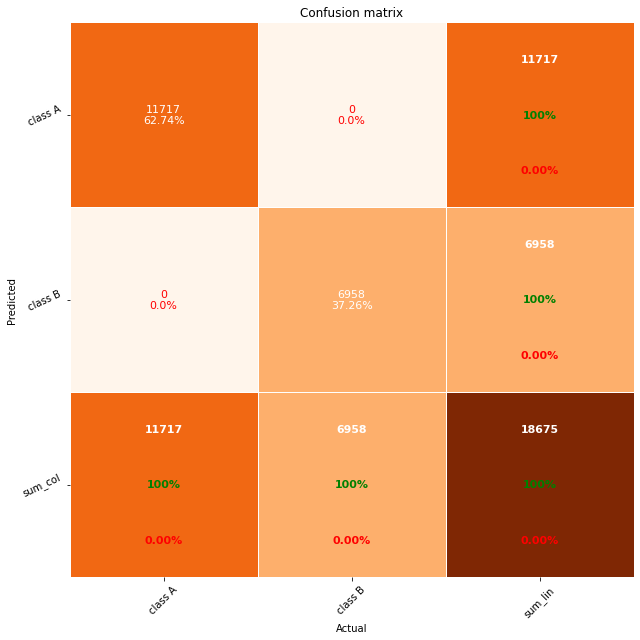

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11717
         1.0       1.00      1.00      1.00      6958

    accuracy                           1.00     18675
   macro avg       1.00      1.00      1.00     18675
weighted avg       1.00      1.00      1.00     18675
 

AUC-ROC


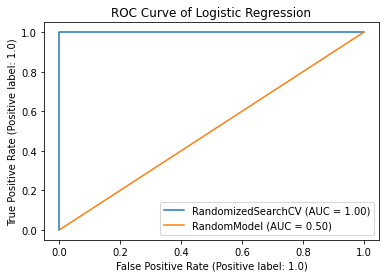

In [34]:
test_eval(clf_LR, X_test, y_test, "Logistic Regression")

In [35]:
SGD = SGDClassifier()

sgd_model = SGDClassifier(
    loss = 'hinge',
    n_jobs = -1,
    alpha = 0.1, # alpha = 1/C and our best C = 10
    penalty = 'elasticnet',
    random_state = 42,
    class_weight = 'balanced'
).fit(X_train, y_train)



Confusion Matrix


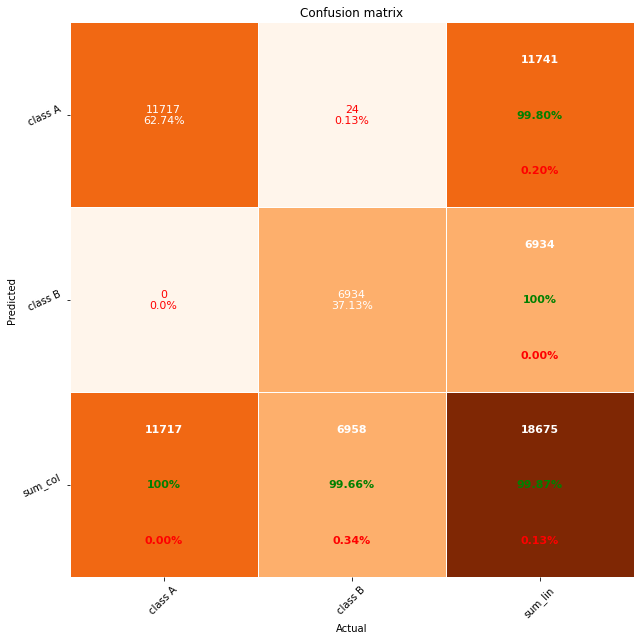

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11717
         1.0       1.00      1.00      1.00      6958

    accuracy                           1.00     18675
   macro avg       1.00      1.00      1.00     18675
weighted avg       1.00      1.00      1.00     18675
 

AUC-ROC


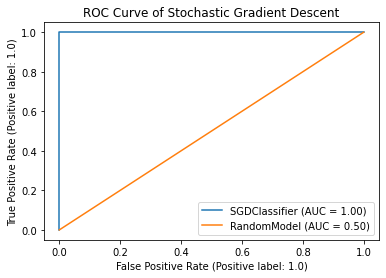

In [36]:
test_eval(sgd_model, X_test, y_test, "Stochastic Gradient Descent")

In [20]:
# Svc_clf = SVC()

# # params={'C' : [0.001, 0.01], 'class_weight':[None,'balanced']}

# # cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# # # Create grid search using 5-fold cross validation
# # Svc_clf = RandomizedSearchCV(Svc, params, cv=cv, scoring='f1', n_jobs=-1)
# Svc_clf.fit(X_train_sm, y_train_sm)

In [21]:
# test_eval(Svc_clf, X_test, y_test, "Support Vector Machine")

### Tree Based Model

Random Forest


In [37]:
rf_clf = RandomForestClassifier().fit(X_train_ru, y_train_ru)

Confusion Matrix


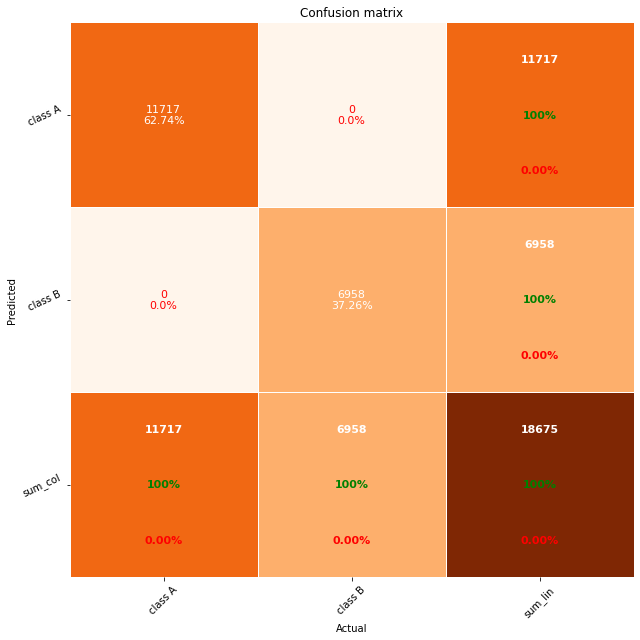

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11717
         1.0       1.00      1.00      1.00      6958

    accuracy                           1.00     18675
   macro avg       1.00      1.00      1.00     18675
weighted avg       1.00      1.00      1.00     18675
 

AUC-ROC


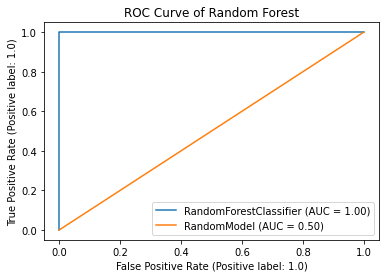

In [38]:
test_eval(rf_clf, X_test, y_test, "Random Forest")

In [40]:
! pip install xgboost

In [41]:
from xgboost import XGBClassifier
from collections import Counter

counter = Counter(y_train)
estimate = counter[0] / counter[1]

gbdt_clf = XGBClassifier(
    n_estimators = 2000,
    max_depth = 2,
    verbosity = 1,
    n_jobs = -1,
    random_state = 42,
    scale_pos_weight = estimate
).fit(X_train_ru, y_train_ru, verbose=1)

C:\ProgramData\Anaconda3\envs\Swiftenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:59:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix


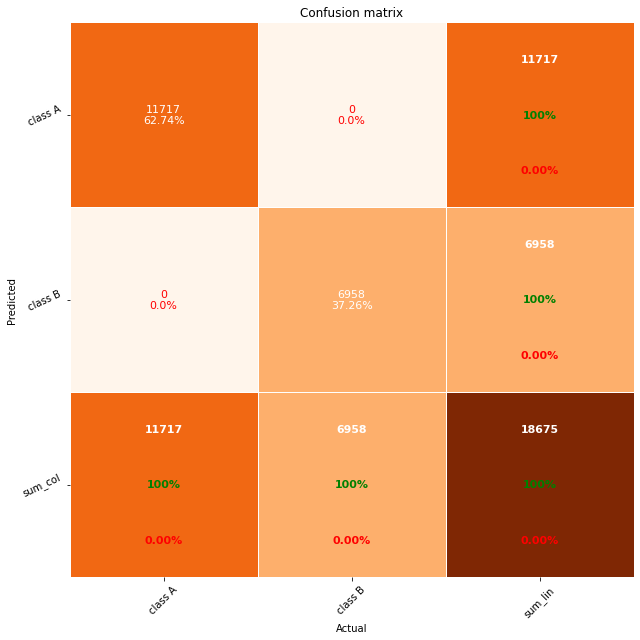

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11717
         1.0       1.00      1.00      1.00      6958

    accuracy                           1.00     18675
   macro avg       1.00      1.00      1.00     18675
weighted avg       1.00      1.00      1.00     18675
 

AUC-ROC


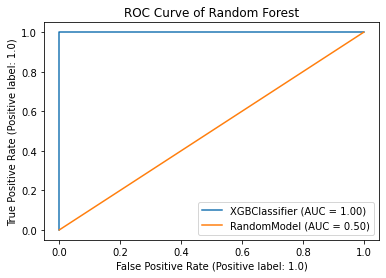

In [42]:
test_eval(gbdt_clf, X_test, y_test, "Xgboost")

In [43]:
final_table = PrettyTable()
final_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

lr_preds = clf_LR.predict(X_test)
sgd_preds = sgd_model.predict(X_test)
rf_preds = rf_clf.predict(X_test)
gbdt_preds = gbdt_clf.predict(X_test)

final_table.add_row([
    'Logistic Regression',
    accuracy_score(y_true = y_test, y_pred = lr_preds),
    f1_score(y_true = y_test, y_pred = lr_preds),
    precision_score(y_true = y_test, y_pred = lr_preds),
    recall_score(y_true = y_test, y_pred = lr_preds),
    log_loss(y_true = y_test, y_pred = lr_preds)
])

final_table.add_row([
    'SGD',
    accuracy_score(y_true = y_test, y_pred = sgd_preds),
    f1_score(y_true = y_test, y_pred = sgd_preds),
    precision_score(y_true = y_test, y_pred = sgd_preds),
    recall_score(y_true = y_test, y_pred = sgd_preds),
    log_loss(y_true = y_test, y_pred = sgd_preds)
])

final_table.add_row([
    'Random Forest',
    accuracy_score(y_true = y_test, y_pred = rf_preds),
    f1_score(y_true = y_test, y_pred = rf_preds),
    precision_score(y_true = y_test, y_pred = rf_preds),
    recall_score(y_true = y_test, y_pred = rf_preds),
    log_loss(y_true = y_test, y_pred = rf_preds)
])

final_table.add_row([
    'XGBoost',
    accuracy_score(y_true = y_test, y_pred = gbdt_preds),
    f1_score(y_true = y_test, y_pred = gbdt_preds),
    precision_score(y_true = y_test, y_pred = gbdt_preds),
    recall_score(y_true = y_test, y_pred = gbdt_preds),
    log_loss(y_true = y_test, y_pred = gbdt_preds)
])

print(final_table)

+---------------------+-------------------+--------------------+-----------+-------------------+-----------------------+
|      Model Name     |      Accuracy     |      F1-Score      | Precision |       Recall      |        Log-loss       |
+---------------------+-------------------+--------------------+-----------+-------------------+-----------------------+
| Logistic Regression |        1.0        |        1.0         |    1.0    |        1.0        | 9.992007221626413e-16 |
|         SGD         | 0.998714859437751 | 0.9982723869853153 |    1.0    | 0.996550732969244 |  0.04438718251554886  |
|    Random Forest    |        1.0        |        1.0         |    1.0    |        1.0        | 9.992007221626413e-16 |
|       XGBoost       |        1.0        |        1.0         |    1.0    |        1.0        | 9.992007221626413e-16 |
+---------------------+-------------------+--------------------+-----------+-------------------+-----------------------+


# Conclusions

- We have gotten a data-set with extremely skewed features and normalized it by applying various transformations.
- We decide our KPI (Key Performance Indicator) to be Recall.
- We have applied various algorithms on the data right from linear models, to tree-based models.
- We find most models achieved a high accuracy and recall score.